In [1]:
###############################################################################
#                                                                             #
#                                                                             #
# Basic tests of SYNEX functions to make sure everything installed correctly. #
#                                                                             #
#                                                                             #
###############################################################################
%matplotlib inline

In [2]:
###########################
#                         #
# Basic starting tests... #
#                         #
###########################

In [3]:
# Import starting packages
import os,sys

# Define SYNEX_PATH variable, add to path if not already there
try:
    from SYNEX.SYNEX_Utils import SYNEX_PATH
except:
    SYNEX_PATH=os.popen('pwd').read().split("SYNEX")[0]+"SYNEX"
    sys.path.insert(1, SYNEX_PATH)

# print(SYNEX_PATH) ### Check this is right.

In [4]:
### Continue importing ###


# required packages
from astropy.time import Time
import numpy as np
import pandas as pd
import healpy as hp
from scipy import stats
import time
from astropy.time import Time


# gwemopt
import gwemopt


# lisabeta
import lisabeta
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.tools.pytools as pytools
import lisabeta.pyconstants as pyconstants
import lisabeta.inference.inference as inference
import lisabeta.utils.plotutils as plotutils


# synex
import SYNEX.SYNEX_Utils as SYU
import SYNEX.SYNEX_Sources as SYSs
import SYNEX.SYNEX_Detectors as SYDs
import SYNEX.SYNEX_Telescopes as SYTs
import SYNEX.segments_athena as segs_a


# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
try:
    import ligo.skymap.plot
    cmap = "cylon"
except:
    cmap = 'PuBuGn'
pylab_params = {'legend.fontsize': 4,
         'axes.labelsize': 4,
         'axes.titlesize': 4,
         'xtick.labelsize': 4,
         'ytick.labelsize': 4,
         'lines.markersize': 0.7,
         'lines.linewidth': 0.7,
         'font.size': 4}
pylab.rcParams.update(pylab_params)


# Stop warnings about deprecated methods...
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Using MPI or not
try:
    from mpi4py import MPI
except ModuleNotFoundError:
    MPI = None

use_mpi=False
is_master = True
mapper = map
if MPI is not None:
    MPI_size = MPI.COMM_WORLD.Get_size()
    MPI_rank = MPI.COMM_WORLD.Get_rank()
    comm_global = MPI.COMM_WORLD
    use_mpi = (MPI_size > 1)
    if use_mpi:
        # print("MPI rank/size: %d / %d" % (MPI_rank, MPI_size), flush=True)
        pool = ptemcee.mpi_pool.MPIPool(debug=False)
        is_master = pool.is_master()
        mapper = pool.map
    else:
        # print("No MPI", flush=True)
        is_master = True
        mapper = map

In [6]:
#####################
#                   #
# lisabeta tests... #
#                   #
#####################

In [7]:
# LISA object params
LISA_base_kwargs = {"TDI":'TDIAET',"verbose":False}

# Create LISA
LISA = SYDs.LISA(**LISA_base_kwargs)







# Source object parameters
# NB Dec = beta and Ra = lambda (more or less)
#Merger_kwargs = {
#        "q": 3, "M": 2e7, "chi1": 0.9, "z": 2., # "dist":13600., # 
#        "chi2": 0.95, "beta" : np.pi/3., "lambda" : np.pi/6.,
#        "inc": 40.3*np.pi/180., "psi": 0.,  "approximant" : 'IMRPhenomHM',
#        "Lframe":True, "DeltatL_cut":-3*7*24*60*60,
#        "verbose":False,
#        "ExistentialFileName":SYNEX_PATH+"/Saved_Source_Dicts/Test_system.dat",
#        "JsonFile":"Test_system"
#}

Merger_kwargs = {
        "q": 1.1, "M": 5e7, "chi1": 0.9, "z": 3.11, # "dist":13600., # 
        "chi2": 0.95, "beta" : -1.*np.pi/8., "lambda" : np.pi/3.,
        "inc": np.pi/10., "psi": 0.4, "phi":0., "approximant" : 'IMRPhenomHM',
        "Lframe":True, "DeltatL_cut":-24*60*60, # Stop one day before merger event.
        "verbose":False,
        "ExistentialFileName":SYNEX_PATH+"/Saved_Source_Dicts/Test_system.dat",
        "JsonFile":"Test_system",
        "MUTATED":False
}

# Create source
Merger=SYSs.SMBH_Merger(**Merger_kwargs)





# Inference params definition with prior ranges and types
inference_params = {
    "infer_params": ["chi1", "chi2", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "params_range": [[-1., 1.], [-1., 1.], [5e3, 2e5], [0.,np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi/2.,np.pi/2.], [0.,np.pi]],
    "prior_type": ["uniform", "uniform", "uniform", "sin", "uniform", "uniform", "cos", "uniform"],
    "wrap_params": None
}

# Parameters governing MCMC inference -- NB: samples used are SMALL to reduce runtime. Larger numbers commented out are recommended for proper inference runs.
RunTimekwargs = {
    "print_info": True,
    "n_walkers":  32, # 96,
    "n_iter": 8500, # 8000, # 15000, # 
    "burn_in": 5000, # 4000, # 5000, # 
    "autocor_method": "autocor_new",
    "thin_samples": True, # False,
    "multimodal": True,
    "multimodal_pattern": "8modes",
    "p_jump": 0.5,
    "init_method": "fisher",
    "skip_fisher": False,
    "n_temps": 10,
    "output_raw":False
}



# Write params to json file
SYU.WriteParamsToJson(Merger,LISA,inference_params,is_master,**RunTimekwargs)
print("Json file created for source at: ../SYNEX/"+Merger.JsonFile.split("/SYNEX/")[-1])



Json file created for source at: ../SYNEX/inference_param_files/Test_system.json


Merger detected by LISA with SNR: 15.725502514959496


<Figure size 640x480 with 0 Axes>

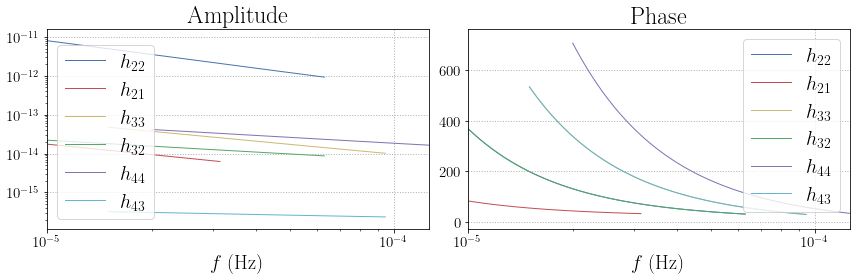

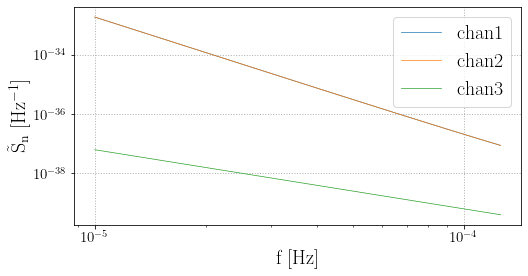

In [8]:
### Basic tests of source

# Plot params
%matplotlib inline
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.figure(figsize=(8, 6), dpi=80)


# SNR
SNR = SYU.ComputeSNR(Merger, LISA, freqs=None, Lframe=False, ReturnAllVariable=False)
print("Merger detected by LISA with SNR:",SNR)



# Get signal
wftdi = SYU.GetSMBHGWDetection(Merger, LISA, **{})


# Amplitude and phase of h_lm, summed over all channels
labels = [r'$h_{22}$', r'$h_{21}$', r'$h_{33}$', r'$h_{32}$', r'$h_{44}$', r'$h_{43}$']
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], *[[wftdi[lm]['freq'], wftdi[lm]['amp']] for lm in wftdi['modes'] if len(wftdi[lm]['freq'])>0], labels=[lab for lab,lm in zip(labels,wftdi['modes']) if len(wftdi[lm]['freq'])>0])
plotutils.lloglinearplot(axs[1], *[[wftdi[lm]['freq'], wftdi[lm]['phase']] for lm in wftdi['modes'] if len(wftdi[lm]['freq'])>0], labels=[lab for lab,lm in zip(labels,wftdi['modes']) if len(wftdi[lm]['freq'])>0])
for i in range(2): axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper right')
axs[0].set_title(r'Amplitude')
axs[1].set_title(r'Phase')
fig.tight_layout()


# Create LISA noise
SYU.ComputeDetectorNoise(Merger, LISA)

# Plot noise
plt.loglog(LISA.Snvals["freqs"], LISA.Snvals["chan1"], label="chan1")
plt.loglog(LISA.Snvals["freqs"], LISA.Snvals["chan2"], label="chan2")
plt.loglog(LISA.Snvals["freqs"], LISA.Snvals["chan3"], label="chan3")

# labels
plt.xlabel(r"f [Hz]")
plt.ylabel(r"$\tilde{\mathrm{S}}_{\mathrm{n}}$ [Hz$^{-1}$]")
plt.legend()

# Show and grid
# plt.grid()
plt.show()


In [ ]:
# Begin inference if the test_file doesn't already exist (this takes time...)
t0 = time.time()
if not os.path.isfile(Merger.H5File):
    if use_mpi:
        os.system("time mpirun -np 10 python3 " + SYNEX_PATH + "/lisabeta/lisabeta/inference/ptemcee_smbh.py " + Merger.JsonFile + "> ${SLURM_SUBMIT_DIR}/lisabeta_test_run.txt")
    else:
        os.system("python3 " + SYNEX_PATH + "/lisabeta/lisabeta/inference/ptemcee_smbh.py " + Merger.JsonFile)
t1 = time.time()

print("Time to completion:",(t1-t0)/60,"min") ### Around 1hr08min. Reduce RunTimekwargs["n_walkers"], RunTimekwargs["n_iters"], and RunTimekwargs["burn_in"] if you don't want to wait.

### NOTE: you may need to run this in a seperate shell script when testing on cluster. See the SYNEX manual
#         for example shell scripts in section `Running on cluster'.



No MPI


In [ ]:
# See inference results
SYU.PlotInferenceData(Merger.H5File, SaveFig=False)

# See just lambda and beta (equivalent of RA and Dec)
# Note: convention in lisabeta is slightly different with RA <--> lattitude.
# Note: red is true location, blue is best fit posterior.
SYU.PlotInferenceLambdaBeta(Merger.H5File, bins=50, SkyProjection=False, SaveFig=False, return_data=False)

In [ ]:
# Calculate the skymap
Merger.sky_map = Merger.H5File.split("inference_data")[0] + 'Skymap_files' + Merger.H5File.split("inference_data")[-1].strip(".h5")
Merger.CreateSkyMapStruct(SkyMapFileName=None)

# See the skymap
SYU.PlotSkyMapData(Merger,SaveFig=False,plotName=None)

# Save everthing again
Merger.ExistentialCrisis()


In [ ]:
### Sky areas:

# Fisher sky area NB: No inference is needed, just an instance of system and LISA
#fishercov = SYU.GetFisher_smbh(Merger, LISA, **{})
#SkyArea = lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)
SkyArea_fisher = Merger.FisherSkyArea

# Posterior sky area NB Inference must be run since we are calculating from MCMC posteriors... Precision vs time and all that.
SkyArea_post = Merger.PostSkyArea

# Try older function to see the difference
tmp_area=SYU.GetTotSkyAreaFromPostData_OLD(Merger.H5File)

# print
print(r"SkyArea according to Fisher inf. matrix:",SkyArea_fisher,r"deg^2")
print(r"SkyArea according to MCMC inference posteriors:",SkyArea_post,r"deg^2")
print(r"SkyArea according to OLD posterior functon:",tmp_area,r"rad^2, or",tmp_area*(180/np.pi)**2,r"deg^2")


In [ ]:
####################
#                  #
# GWEMOpt tests... #
#                  #
####################

In [ ]:
### Athena Object ###


# Telescope args
t0 = '2034-01-01T00:00:00.00'
t = Time(t0, format='isot', scale='utc').gps
Athena_kwargs={
                "ExistentialFileName":SYNEX_PATH+"/Saved_Telescope_Dicts/Athena_test.dat",
                "verbose":False,
                "telescope":"Athena_test",
                "orbitFile":"/SYNEX/orbit_files/Athena_test.dat", ## Need to include test for this
                "Tobs":np.array([0.,9.]),
                "tilesType" : "moc",
                "timeallocationType" : "powerlaw",
                "scheduleType" : "greedy",
                "doCalcTiles" : False,
                "Ntiles" : None,
                "frozenAthena" : False,
                "exposuretime" : 10000.,
                "min_observability_duration" : None,
                "inc" : 60.,
                "MeanRadius" : 750000000.,
                "semi_maj" : 750000000.,
                "eccentricity" : 0.4,
                "ArgPeriapsis" : 20.,
                "AscendingNode" : -10.,
                "phi_0" : 10.,
                "period" : 90.,
                "gps_science_start" : t,
                "mission_duration" : 2.,
                "filt_change_time" : 0.,
                "overhead_per_exposure" : 0.,
                "latitude" : 0.,
                "longitude" : 0.,
                "elevation" : 0.,
                "slew_rate" : 1.,
                "horizon" : 0.,
                "doMinimalTiling" : True,
                "readout" : 0.0001,
                "doSingleExposure" : True,
                "iterativeOverlap" : 0.,
                "maximumOverlap" : 1.0,
                "sat_sun_restriction" : 5.,
                "sat_earth_constraint" : 5.,
                "sat_moon_constraint" : 5.,
}

# Create Athena
Athena=SYTs.Athena(**Athena_kwargs)




In [ ]:
# Plot calculated Athena orbit -- size of circles correspond to angular diameters of each object as viewed by Athena
config_struct = segs_a.calc_telescope_orbit(Athena.telescope_config_struct,SAVETOFILE=False)
SYU.PlotOrbit(config_struct, SaveFig=False) ## Might move this to within the Athena class to avoid dealing with config struct.

# Animate the trajectory to be fancy (might need to do at command line or save in order to render animation)
SYU.AnimateOrbit(config_struct,include_sun=False,SaveAnim=False)

print(Athena.telescope_config_struct["mission_duration"], config_struct["mission_duration"])


In [ ]:
# Generate EM flux based on a simple flat flux (this step is checked for inside tiling functions. we call it here just to show how to do it.)
EM_kwargs={}
Merger.GenerateEMFlux(fstart22=1e-4,TYPE="const",**EM_kwargs)

# Calculate CTR based on Athena object (this step is checked for inside tiling functions. we call it here just to show how to do it.)
Merger.GenerateCTR(Athena.ARF_file_loc_name,gamma=1.7)
  

In [ ]:
# tile with GWEMOpt -- returns a list of detectors based on how many tilings asked for
Athena = SYU.TileSkyArea(sources=Merger,telescopes=Athena,verbose=False)


In [ ]:
##### Plot stuff using gwemopt internal plotting functions

# gwemtop uses different architectures so need to reorder some stuff before plotting (SYNEX equiv. function in progress)
go_params,map_struct=SYU.PrepareGwemoptDicts(Merger,Athena[0])
TileStructs = {Ath.telescope_config_struct["telescope"]:Ath.telescope_tile_struct for Ath in Athena}

# Plot all tiles (SYNEX equiv. function in progress)
gwemopt.plotting.tiles(go_params, map_struct, TileStructs)


In [ ]:
### Repeat but with cloning of Tobs

#### Filename is still adding exfimename to the filename...

# Define what we want to iterate tiling over
T_obs_array = [np.array([0.,1.]),np.array([0.,2.]),np.array([0.,3.]),np.array([0.,4.])]
cloning_params={"Tobs":T_obs_array} # Tobs in days = total observation time available for Athena to tile

# Some output options
SaveInSubFile = "Test_functions"
SaveFileCommonStart = "System"

# tile with GWEMOpt -- returns a list of detectors based on how many tilings asked for
Athenas_out = SYU.TileSkyArea(sources=Merger,base_telescope_params=Athena_kwargs,cloning_params=cloning_params,SaveInSubFile=SaveInSubFile,SaveFileCommonStart=SaveFileCommonStart,verbose=False)

# See now why we output a list of detectors;
print("\n\n")
print(len(Athenas_out),"detector params passed back from tiling function, with total observation times:")
for Ath in Athenas_out: print(Ath.telescope_go_params["Tobs"])
    

In [ ]:
# Access some interesting information regaring the tiling process
for i,Athena in enumerate(Athenas_out):
    print("Tobs:",Athena.telescope_go_params["Tobs"],"found source",len(Athena.telescope_source_coverage["Source tile timeranges (isot)"]),"times, collecting",sum(Athena.telescope_source_coverage["Source photon counts"]),"total photons from the source at tile time ranges",Athena.telescope_source_coverage["Source tile timeranges (isot)"],"\n")

# Put all the info into a pandas dataframe cause this is just easier
data=SYU.GetDataFrame(telescopes=Athenas_out,SaveFile="Test_system")

###
# Note - the dataframe approach is very useful if at anytime you want to compare
# a set of detectors with completed tiling. You pass a list of savefile names and
# the function will hand back a dataframe with columns equal to the useful information.
###

# Show data
data.head()


In [ ]:

##### Plot schedule results using gwemopt internal plotting functions

# gwemtop uses different architectures so need to reorder some stuff before plotting (SYNEX equiv. function in progress)
SYU.PlotCoverage(Merger,Athenas_out[0])

# Plot dictionaries (SYNEX equiv. function in progress)
# gwemopt.plotting.scheduler(go_params,exposurelist,keys) -- this function is tricky to get right; adaptation to SYNEX on TO DO list.



#######
#
# NB: you can add go_params["doPlots"]=True, or add "doPlots":True option to Athena kwargs at initiation to output
#     all posible plots that gwemopt as internally.
#
#######
